In [ ]:
# Install Hugging Face transformers if not installed
!pip install transformers
!pip install datasets
!pip install torch scikit-learn

# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Load dataset from Google Drive (Update path)
df = pd.read_csv("/content/drive/MyDrive/Suicide_Detection.csv")
# Preview dataset
df.head()


Mounted at /content/drive


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [ ]:
# Balance dataset (equal suicide & non-suicide posts)
suicide = df[df['class'] == 'suicide'].head(30000)
non_suicide = df[df['class'] == 'non-suicide'].head(30000)
df_balanced = pd.concat([suicide, non_suicide]).reset_index(drop=True)

# Encode labels (suicide = 1, non-suicide = 0)
label_map = {'suicide': 1, 'non-suicide': 0}
df_balanced['label'] = df_balanced['class'].map(label_map)

# Convert to Hugging Face dataset format
dataset = Dataset.from_pandas(df_balanced[['text', 'label']])


In [ ]:
# Use DistilBERT for faster training (~60% faster than BERT)
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Apply tokenization
tokenized_datasets = dataset.map(tokenize_function, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

In [ ]:
# Use only 50% of training data for faster debugging (remove this later for full dataset)
train_test_split = tokenized_datasets.train_test_split(test_size=0.2, train_size=0.5, seed=42)

# Define train & test datasets
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]


In [ ]:
# Load pre-trained DistilBERT model for binary classification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define custom evaluation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


In [ ]:
!pip install --upgrade transformers

In [ ]:
!pip install --upgrade transformers  # Ensure transformers is up-to-date


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    # Replace 'evaluation_strategy' with the correct parameter if it's outdated
    # For example, it might be 'eval_strategy' in older versions
    # evaluation_strategy="epoch",
    # The above line is commented out and replaced by the following one.
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",      # Save at the end of each epoch
    num_train_epochs=5,  # Reduce epochs for speed
    per_device_train_batch_size=8,  # Increase batch size
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    fp16=True,  # Enable mixed precision (faster training)
    # Add any new required parameters
    # For example:
    # save_strategy = "epoch",
    # evaluation_strategy = "epoch"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: u1909015 (u1909015-chittagong-university-scientific-society) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.154000,0.144399,0.958583,0.958820,0.951645,0.966105
2,0.093900,0.168107,0.961500,0.961660,0.955948,0.967440
3,0.055500,0.226449,0.959500,0.959167,0.965331,0.953081
4,0.011800,0.287868,0.961083,0.961383,0.952326,0.970613
5,0.001900,0.298441,0.962333,0.962258,0.962419,0.962097


TrainOutput(global_step=18750, training_loss=0.074481829884847, metrics={'train_runtime': 1173.5945, 'train_samples_per_second': 127.812, 'train_steps_per_second': 15.977, 'total_flos': 4967527449600000.0, 'train_loss': 0.074481829884847, 'epoch': 5.0})

In [ ]:
# Evaluate on test set
results = trainer.evaluate()
print("Optimized BERT Evaluation Results:", results)


Optimized BERT Evaluation Results: {'eval_loss': 0.1443987488746643, 'eval_accuracy': 0.9585833333333333, 'eval_f1': 0.9588201176568067, 'eval_precision': 0.9516447368421053, 'eval_recall': 0.9661045249624312, 'eval_runtime': 12.5469, 'eval_samples_per_second': 956.411, 'eval_steps_per_second': 59.776, 'epoch': 5.0}


In [ ]:
# Example texts for classification
test_texts = ["I feel so hopeless and alone.", "Today is a good day!"]

# Ensure test_encodings are on the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Get the device the model is on
test_encodings = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt").to(device) # Move to the same device

# Predict
outputs = model(**test_encodings)
predictions = torch.argmax(outputs.logits, dim=1)

# Print predictions (1 = suicide, 0 = non-suicide)
print("Predictions:", predictions.tolist())

Predictions: [1, 0]


In [ ]:
# Example texts for classification
test_texts = ["I feel alone", "I am feeling suicidal!"]

# Ensure test_encodings are on the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Get the device the model is on
test_encodings = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt").to(device) # Move to the same device

# Predict
outputs = model(**test_encodings)
predictions = torch.argmax(outputs.logits, dim=1)

# Print predictions (1 = suicide, 0 = non-suicide)
print("Predictions:", predictions.tolist())

Predictions: [0, 1]


In [ ]:
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Training samples: 30000
Test samples: 12000


In [ ]:
logging_dir="./logs",
logging_strategy="epoch",  # log every epoch

In [ ]:
# Get training logs (all epochs)
history = trainer.state.log_history

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame
df_history = pd.DataFrame(history)

# Filter for loss and F1 entries
train_loss = df_history[df_history['loss'].notna()]
eval_loss = df_history[df_history['eval_loss'].notna()]
eval_f1 = df_history[df_history['eval_f1'].notna()]


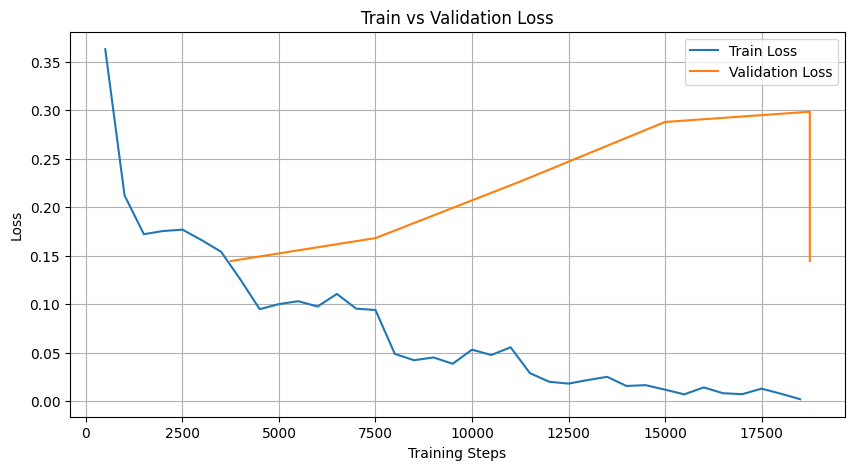

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss['step'], train_loss['loss'], label='Train Loss')
plt.plot(eval_loss['step'], eval_loss['eval_loss'], label='Validation Loss')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

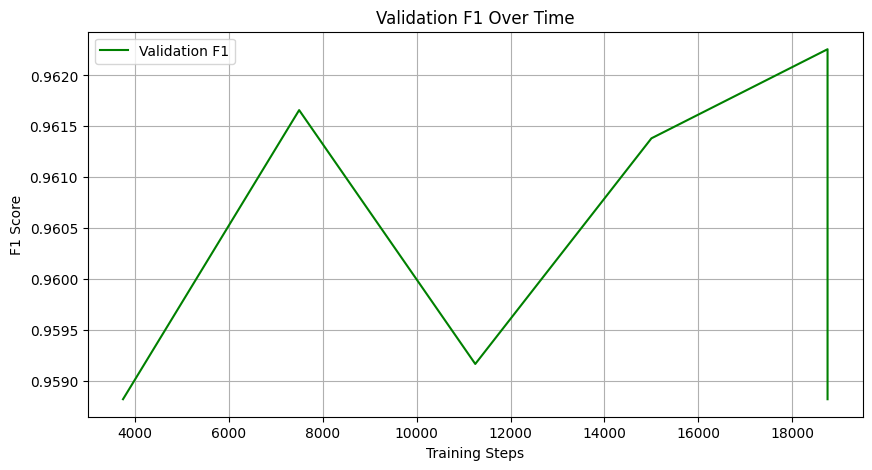

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(eval_f1['step'], eval_f1['eval_f1'], label='Validation F1', color='green')
plt.xlabel("Training Steps")
plt.ylabel("F1 Score")
plt.title("Validation F1 Over Time")
plt.legend()
plt.grid(True)
plt.show()

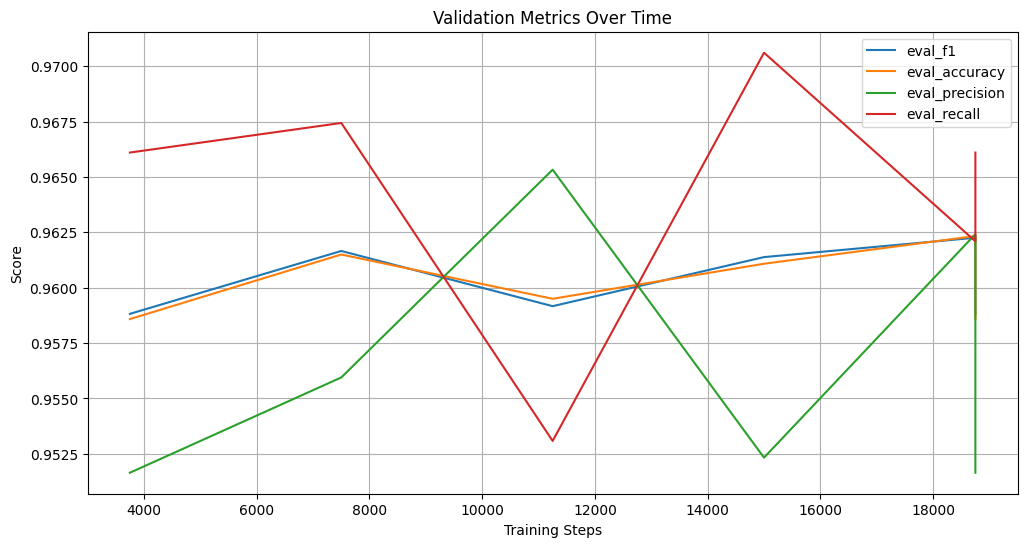

In [ ]:
metrics = ['eval_f1', 'eval_accuracy', 'eval_precision', 'eval_recall']

plt.figure(figsize=(12, 6))
for metric in metrics:
    if metric in df_history.columns:
        metric_data = df_history[df_history[metric].notna()]
        plt.plot(metric_data['step'], metric_data[metric], label=metric)
plt.xlabel("Training Steps")
plt.ylabel("Score")
plt.title("Validation Metrics Over Time")
plt.legend()
plt.grid(True)
plt.show()

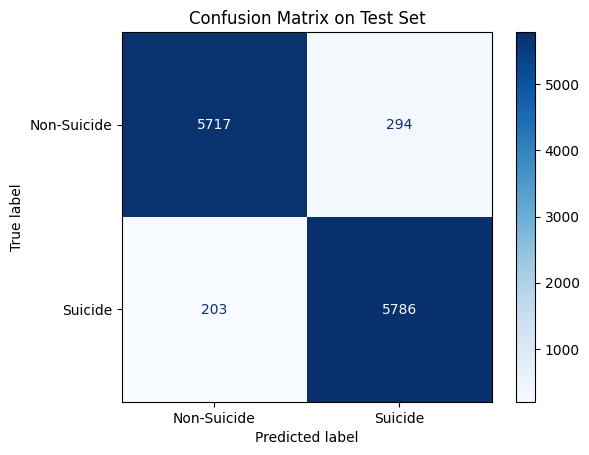

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
# Use test_dataset instead of tokenized_datasets['test']
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Suicide', 'Suicide'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.show()

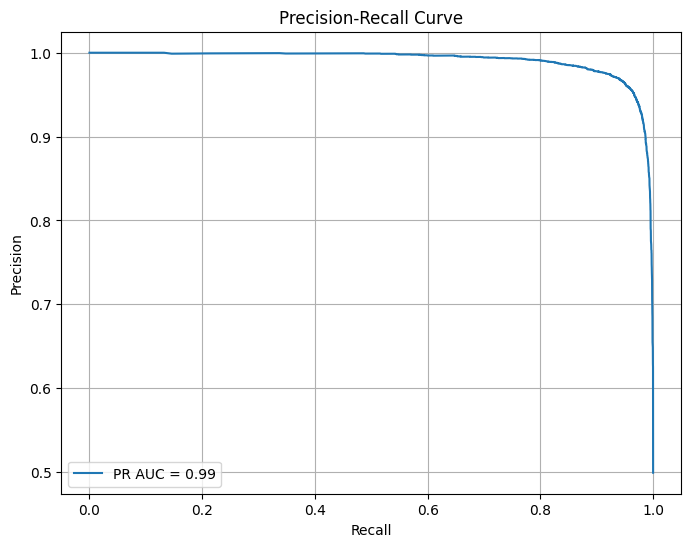

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

probs = predictions.predictions[:, 1]  # Probability for class 1
precision, recall, thresholds = precision_recall_curve(y_true, probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()